In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip

In [3]:
#!unzip processed-celeba-small.zip

In [4]:
cd /content/drive/MyDrive/GuidedGAN/

/content/drive/MyDrive/GuidedGAN


In [18]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
#import helper

%matplotlib inline

In [19]:
data_dir = 'processed_celeba_small/'

In [6]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
	"""
	Batch the neural network data using DataLoader
	:param batch_size: The size of each batch; the number of images in a batch
	:param img_size: The square size of the image data (x, y)
	:param data_dir: Directory where image data is located
	:return: DataLoader with batched data
	"""
	transform = transforms.Compose([transforms.Resize(image_size),
									transforms.ToTensor()])
	data = datasets.ImageFolder(data_dir, transform=transform)
	dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=0)
	return dataloader

In [7]:
pwd

'/content/drive/MyDrive/GuidedGAN'

In [8]:
# Define function hyperparameters
batch_size = 128
img_size = 32

# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


In [9]:
# helper display function
def imshow(img):
	npimg = img.numpy()
	plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [15]:
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = next(dataiter) # _ for no labels

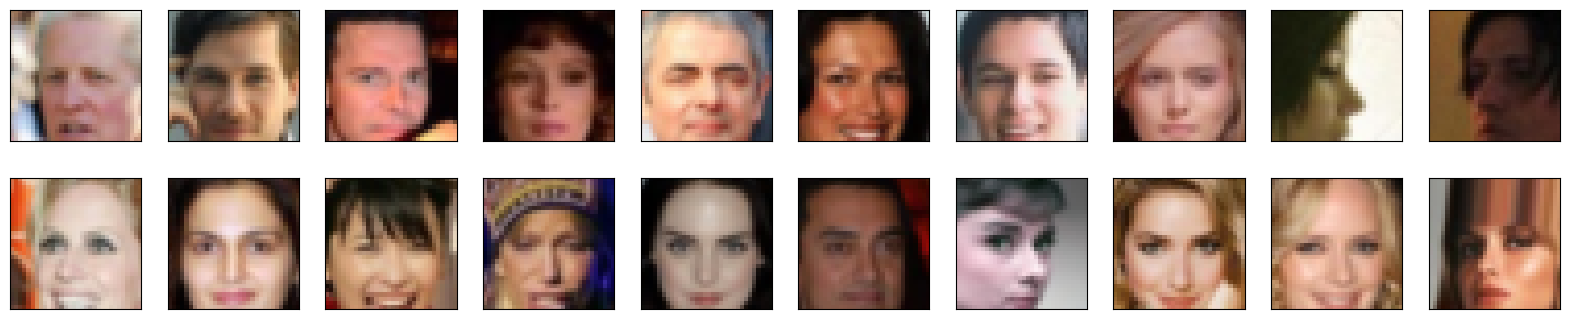

In [21]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [22]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0431)
Max:  tensor(0.9882)


In [23]:
#scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1.
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [24]:
# check scaled range
# should be close to -1 to 1
#img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9137)
Max:  tensor(0.9765)


In [25]:
import torch.nn as nn
import torch.nn.functional as F

In [26]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels,
                           kernel_size, stride, padding, bias=False)

    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))

    # using Sequential container
    return nn.Sequential(*layers)

In [27]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        self.fc = nn.Linear(conv_dim*8*2*2, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = out.view(-1, self.conv_dim*8*2*2)
        out = self.fc(out)

        return out



In [28]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels,
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [29]:
class Generator(nn.Module):

    def __init__(self, z_size, conv_dim=32):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)
        self.t_conv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv3 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv4 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8, 2, 2)
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.relu(self.t_conv3(out))
        out = self.t_conv4(out)
        out = F.tanh(out)

        return out



In [30]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__

    # Apply initial weights to convolutional and linear layers
    if  hasattr(m, 'weight') and classname.find('Conv') or classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)

In [31]:

def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)

    return D, G

In [32]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

In [33]:


# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [34]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    # smooth, real labels = 0.9
    labels = torch.ones(batch_size)*0.9
    # move labels to GPU if available
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [35]:
import torch.optim as optim

lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [36]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''

    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            g_loss.backward()
            g_optimizer.step()



            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    # finally return losses
    return losses

In [37]:
# set number of epochs
n_epochs = 15


# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   15] | d_loss: 1.3877 | g_loss: 0.6956
Epoch [    1/   15] | d_loss: 0.9368 | g_loss: 1.0029
Epoch [    1/   15] | d_loss: 0.6121 | g_loss: 1.4784
Epoch [    1/   15] | d_loss: 0.4985 | g_loss: 2.0130
Epoch [    1/   15] | d_loss: 0.4576 | g_loss: 2.2162
Epoch [    1/   15] | d_loss: 0.4794 | g_loss: 2.3212
Epoch [    1/   15] | d_loss: 0.8615 | g_loss: 1.7176
Epoch [    1/   15] | d_loss: 0.8648 | g_loss: 1.6468
Epoch [    1/   15] | d_loss: 0.9296 | g_loss: 1.5092
Epoch [    1/   15] | d_loss: 0.8286 | g_loss: 1.9362
Epoch [    1/   15] | d_loss: 1.3078 | g_loss: 2.4670
Epoch [    1/   15] | d_loss: 1.3601 | g_loss: 1.7510
Epoch [    1/   15] | d_loss: 0.9112 | g_loss: 1.5652
Epoch [    1/   15] | d_loss: 0.9885 | g_loss: 1.6392
Epoch [    1/   15] | d_loss: 0.9515 | g_loss: 1.4172
Epoch [    2/   15] | d_loss: 0.8536 | g_loss: 2.4210
Epoch [    2/   15] | d_loss: 0.8899 | g_loss: 2.4162
Epoch [    2/   15] | d_loss: 1.0169 | g_loss: 1.7708
Epoch [    2/   15] | d_loss

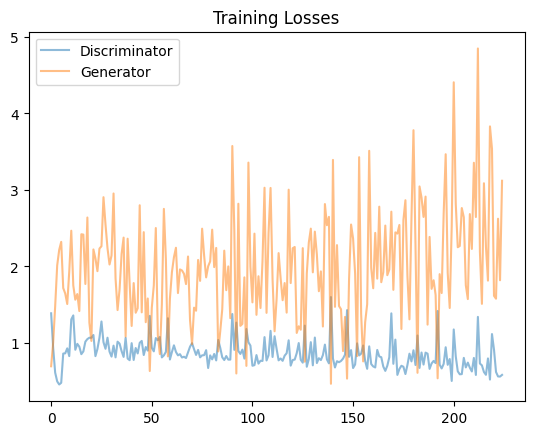

In [38]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [39]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [40]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

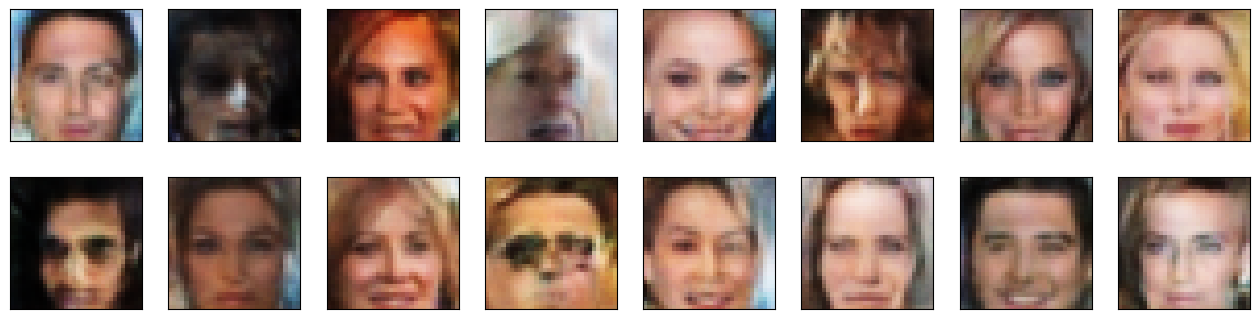

In [41]:
_ = view_samples(-1, samples)

In [42]:
pwd

'/content/drive/MyDrive/GuidedGAN'

In [43]:
ls

__MACOSX/  processed_celeba_small/  processed-celeba-small.zip  train_samples.pkl
